# 🎯 Phishing Website Detection Project

This project aims to build a **Binary Classification** model to detect whether a website is **Phishing** or **Legitimate**, using a dataset containing information about more than 11,000 websites.

## 🧾 Dataset Description:
Each row in the dataset represents a website and contains **30 features** that describe various attributes, such as:
- Presence of an IP address in the URL
- Use of URL shortening services
- Number of subdomains
- Presence of '@' symbol in the URL
- Usage of HTTPS
- Domain registration length
- Alexa ranking, and more...

The last column represents the **label (target)**:
- `1` → **Phishing**
- `-1` → **Legitimate**

## 🛠️ Project Objective:
To implement a **Decision Tree Classifier from scratch, Random Forest, Adaboost** (without using libraries like Scikit-Learn) that:
- Trains on the dataset
- Predicts whether a website is phishing or legitimate
- Evaluates the performance using:
  - **Accuracy**
  - **Confusion Matrix**
  - **Precision, Recall, and F1-Score**



In [55]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



# splitting The dataset into training and testing sets

In [56]:
# This code assumes you have a dataset in CSV format named 'phishing.csv'
# Load the dataset
df = pd.read_csv('phishing.csv')

# Split into features (X) and target (y)
X = df.drop('class', axis=1) 
y = df['class']

# Split into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert DataFrame / Series to NumPy arrays for compatibility with our tree
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


# Entropy and Information Gain

## Entropy

Entropy measures the uncertainty or impurity in a dataset.

$$
H(Y) = - \sum_{i=1}^{c} p_i \log_2 p_i
$$

- \(c\): Number of classes  
- \(p_i\): Probability of class \(i\) in the dataset \(Y\)  

Entropy is 0 when all samples belong to one class (pure), and maximum when classes are evenly distributed.

---

## Information Gain

Information Gain measures the reduction in entropy after a dataset is split on an attribute.

$$
IG(Y, X) = H(Y) - \sum_{v \in \text{Values}(X)} \frac{|Y_v|}{|Y|} H(Y_v)
$$

- \(H(Y)\): Entropy of the parent dataset  
- \(Y_v\): Subset of \(Y\) for which attribute \(X\) has value \(v\)  
- \(|Y_v|\): Number of samples in subset \(Y_v\)  
- \(|Y|\): Number of samples in parent dataset  

Information Gain is used to select the attribute that best splits the data to reduce uncertainty.


## 🧠 Decision Tree - Overview

A **Decision Tree** is a supervised machine learning algorithm used for **classification** and **regression** tasks.

It works by **splitting** the dataset into subsets based on the value of input features, forming a **tree-like structure**:

- Each **internal node** represents a decision based on a feature.
- Each **branch** represents the outcome of that decision.
- Each **leaf node** represents a final prediction (class or value).

The tree selects the best features using metrics like **Information Gain** (based on **Entropy**) to reduce uncertainty at each split.




In [57]:
# ------------------- ENTROPY & INFORMATION GAIN -------------------
def entropy(y):
    counts = Counter(y)
    total = len(y)
    ent = 0
    for count in counts.values():
        p = count / total
        ent -= p * np.log2(p)
    return ent

def info_gain(y, left_indices, right_indices): #It tells you how much uncertainty (entropy) you reduce by splitting your data
    y_left = y[left_indices]
    y_right = y[right_indices]
    parent_entropy = entropy(y)
    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)
    child_entropy = (n_left / n) * entropy(y_left) + (n_right / n) * entropy(y_right)
    gain = parent_entropy - child_entropy # tells us how much uncertainty (entropy) drops if we split on that feature.
    return gain

# ------------------- BEST SPLIT -------------------
def best_split(X, y):
    best_feature = None
    best_threshold = None
    best_gain = -1

    n_samples, n_features = X.shape #Get number of samples (rows) and number of features (columns) in the dataset.

    for feature in range(n_features):
        values = np.unique(X[:, feature])
        for threshold in values:
            left_indices = np.where(X[:, feature] <= threshold)[0]
            right_indices = np.where(X[:, feature] > threshold)[0]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            gain = info_gain(y, left_indices, right_indices)

            if gain > best_gain:
                best_gain = gain
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold, best_gain

# ------------------- NODE CLASS -------------------
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # Only for leaf nodes

# ------------------- TREE BUILDING -------------------
def build_tree(X, y, depth=0, max_depth=None):
    if len(set(y)) == 1:
        return Node(value=y[0])
    
    if max_depth is not None and depth >= max_depth:
        most_common = Counter(y).most_common(1)[0][0]
        return Node(value=most_common)

    feature, threshold, gain = best_split(X, y)
    if gain == 0:
        most_common = Counter(y).most_common(1)[0][0]
        return Node(value=most_common)

    left_idx = np.where(X[:, feature] <= threshold)[0]
    right_idx = np.where(X[:, feature] > threshold)[0]

    left = build_tree(X[left_idx], y[left_idx], depth + 1, max_depth)
    right = build_tree(X[right_idx], y[right_idx], depth + 1, max_depth)

    return Node(feature, threshold, left, right)

# ------------------- PREDICTION -------------------
def predict_sample(x, node):
    if node.value is not None:
        return node.value
    if x[node.feature] <= node.threshold:
        return predict_sample(x, node.left)
    else:
        return predict_sample(x, node.right)

def predict(X, tree):
    return np.array([predict_sample(x, tree) for x in X])



In [62]:
# printing the accuracy and classification report
def evaluate_model(y_true, y_pred):
    class_names = ['Legitimate', 'Phishing']  # for labels -1 and 1
    print("📊 Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("\n📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    plt.figure(figsize=(6, 5))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(" Confusion Matrix - Phishing Detection")
    plt.show()

In [69]:
def DeceisionTreeClassifier(X_train, y_train, X_test, y_test, max_depth=None):
    """
    Train a Decision Tree Classifier and evaluate its performance.
    
    Parameters:
    - X_train: Training features
    - y_train: Training labels
    - X_test: Testing features
    - y_test: Testing labels
    - max_depth: Maximum depth of the tree (optional)
    
    Returns:
    - None
    """
    # Build the decision tree
    tree = build_tree(X_train, y_train, max_depth=max_depth)
    # Make predictions on the test set
    y_pred = predict(X_test, tree)
    
    # Evaluate the model
    evaluate_model(y_test, y_pred)

📊 Accuracy: 0.9222

📋 Classification Report:

              precision    recall  f1-score   support

  Legitimate       0.97      0.85      0.91       976
    Phishing       0.89      0.98      0.93      1235

    accuracy                           0.92      2211
   macro avg       0.93      0.91      0.92      2211
weighted avg       0.93      0.92      0.92      2211



<Figure size 600x500 with 0 Axes>

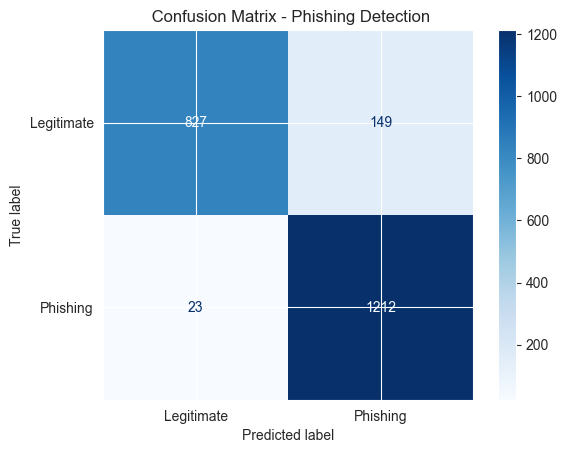

In [70]:
DeceisionTreeClassifier(X_train, y_train, X_test, y_test, max_depth=5)
